# Google trace analysis colab

This colab provides several example queries and graphs using [Altair](https://altair-viz.github.io/) for the 2019 Google cluster trace. Further examples will be added over time.

**Important:** in order to be able to run the queries you will need to:

1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


In [ ]:
#@title Please input your project id
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
# Provide credentials to the runtime
from google.colab import auth
from google.cloud.bigquery import magics

auth.authenticate_user()
print('Authenticated')
project_id = 'poc-marvel' #@param {type: "string"}
# Set the default project id for %bigquery magic
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)

Authenticated


# Basic queries

This section shows the most basic way of querying the trace using the [bigquery magic](https://googleapis.dev/python/bigquery/latest/magics.html)

In [ ]:
%%bigquery
SELECT capacity.cpus AS cpu_cap,
capacity.memory AS memory_cap,
COUNT(DISTINCT machine_id) AS num_machines
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events
GROUP BY 1,2

Query is running:   0%|          |

Downloading:   0%|          |

cpu_cap  memory_cap  num_machines
0        NaN         NaN           459
1   1.000000    0.500000          1672
2   1.000000    1.000000           643
3   1.000000    0.250000            52
4   0.479492    0.250000             1
5   0.708984    0.333496          1417
6   0.708984    0.666992           480
7   0.708984    0.250000             1
8   0.958984    0.500000           179
9   0.958984    1.000000            73
10  0.386719    0.333496          1104
11  0.386719    0.166748           670
12  0.591797    0.333496          3346
13  0.591797    0.166748           364

In [ ]:
%%bigquery
SELECT COUNT(DISTINCT collection_id) AS collections FROM
`google.com:google-cluster-data`.clusterdata_2019_a.collection_events;

Query is running:   0%|          |

Downloading:   0%|          |

collections
0      5212740

# Cell level resource usage time series

This query takes a cell as input and plots a resource usage time-series for every hour of the trace broken down by tier.

In [ ]:
#@title Select a cell and a resource to plot the cell level usage series

def query_cell_capacity(cell):
  return '''
SELECT SUM(cpu_cap) AS cpu_capacity,
  SUM(memory_cap) AS memory_capacity
FROM (
  SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
    MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
  GROUP BY 1
)
  '''.format(cell=cell)

def query_per_instance_usage_priority(cell):
  return '''
SELECT u.time AS time,
  u.collection_id AS collection_id,
  u.instance_index AS instance_index,
  e.priority AS priority,
  CASE
    WHEN e.priority BETWEEN 0 AND 99 THEN '1_free'
    WHEN e.priority BETWEEN 100 AND 115 THEN '2_beb'
    WHEN e.priority BETWEEN 116 AND 119 THEN '3_mid'
    ELSE '4_prod'
  END AS tier,
  u.cpu_usage AS cpu_usage,
  u.memory_usage AS memory_usage
FROM (
  SELECT start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
) AS u JOIN (
  SELECT collection_id, instance_index, machine_id,
    MAX(priority) AS priority
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_events
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  GROUP BY 1, 2, 3
) AS e ON u.collection_id = e.collection_id
  AND u.instance_index = e.instance_index
  AND u.machine_id = e.machine_id
  '''.format(cell=cell)

def query_per_tier_utilization_time_series(cell, cpu_capacity, memory_capacity):
  return '''
SELECT CAST(FLOOR(time/(1e6 * 60 * 60)) AS INT64) AS hour_index,
  tier,
  SUM(cpu_usage) / (12 * {cpu_capacity}) AS avg_cpu_usage,
  SUM(memory_usage) / (12 * {memory_capacity}) AS avg_memory_usage
FROM ({table})
GROUP BY 1, 2 ORDER BY hour_index
  '''.format(table=query_per_instance_usage_priority(cell),
             cpu_capacity=cpu_capacity, memory_capacity=memory_capacity)

def run_query_utilization_per_time_time_series(cell):
  cell_cap = client.query(query_cell_capacity(cell)).to_dataframe()
  query = query_per_tier_utilization_time_series(
      cell,
      cell_cap['cpu_capacity'][0],
      cell_cap['memory_capacity'][0])
  time_series = client.query(query).to_dataframe()
  return time_series

cell = 'c' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
hourly_usage = run_query_utilization_per_time_time_series(cell)

# CPU graph
cpu = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_cpu_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_cpu_usage']
  )
cpu.encoding.x.title = "Hour"
cpu.encoding.y.title = "Average CPU usage"
cpu.display()

# Memory graph
memory = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_memory_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_memory_usage']
  )
memory.encoding.x.title = "Hour"
memory.encoding.y.title = "Average memory usage"
memory.display()

alt.Chart(...)

alt.Chart(...)

#Per machine resource usage distribution

This query takes a cell as input and plots a per-machine resource utilization CDF.

In [ ]:
#@title Select a cell and plot its per-machine resource utilization CDFs

# Functions to plot CDFs using Altair
def pick_quantiles_from_tall_dataframe(data, qcol, name=""):
  quantiles = pd.DataFrame([x for x in data[qcol]]).transpose()
  if name != "":
    quantiles.columns = data[name]
  return quantiles

# - data: a dataframe with one row and one or more columns of quantiles (results
#   returned from APPROX_QUANTILES)
# - qcols: a list of names of the quantiles
# - names: the names of each returned quantiles' columns.
def pick_quantiles_from_wide_dataframe(data, qcols, names=[]):
  quantiles = {}
  i = 0
  for qcol in qcols:
    col_name = qcol
    if i < len(names):
      col_name = names[i]
    quantiles[col_name] = data[qcol][0]
    i+=1
  return pd.DataFrame(quantiles)

# - quantiles: a dataframe where each column contains the quantiles of one
#   data set. The index (i.e. row names) of the dataframe is the quantile. The
#   column names are the names of the data set.
def plot_cdfs(quantiles, xlab="Value", ylab="CDF",
              legend_title="dataset", labels=[],
              interactive=False,
              title=''):
  dfs = []
  label = legend_title
  yval = range(quantiles.shape[0])
  esp = 1.0/(len(quantiles)-1)
  yval = [y * esp for y in yval]
  while label == xlab or label == ylab:
    label += '_'
  for col_idx, col in enumerate(quantiles.columns):
    col_label = col
    if col_idx < len(labels):
      col_label = labels[col_idx]
    dfs.append(pd.DataFrame({
        label: col_label,
        xlab: quantiles[col],
        ylab: yval
    }))
  cdfs = pd.concat(dfs)
  lines = alt.Chart(cdfs).mark_line().encode(
    # If you can draw a CDF, it has to be continuous real-valued
    x=xlab+":Q",
    y=ylab+":Q",
    color=label+":N"
  ).properties(
    title=title
  )
  if not interactive:
    return lines
  # Create a selection that chooses the nearest point & selects based on x-value
  nearest = alt.selection_point(nearest=True, on='mouseover', # Changed to alt.selection_point
                        fields=[ylab], empty='none')
  # Transparent selectors across the chart. This is what tells us
  # the y-value of the cursor
  selectors = alt.Chart(cdfs).mark_point().encode(
    y=ylab+":Q",
    opacity=alt.value(0),
  ).add_selection(
    nearest # Apply selection to this chart
  )

  # Draw text labels near the points, and highlight based on selection
  text = lines.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest,
                       alt.Text(xlab+":Q", format=".2f"),
                       alt.value(' ')),
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)) # Apply opacity condition here
  )

  # Draw a rule at the location of the selection
  rules = alt.Chart(cdfs).mark_rule(color='gray').encode(
    y=ylab+":Q",
  ).transform_filter(
    nearest  # Use nearest directly
  )
  # Draw points on the line, and highlight based on selection
  points = lines.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
  )
  # Put the five layers into a chart and bind the data
  return alt.layer(lines, selectors, rules, text, points).interactive(
      bind_y=False)

# Functions to create the query

def query_machine_capacity(cell):
  return '''
SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
  MAX(capacity.memory) AS memory_cap
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
GROUP BY 1
  '''.format(cell=cell)

def query_top_level_instance_usage(cell):
  return '''
SELECT CAST(FLOOR(start_time/(1e6 * 300)) * (1000000 * 300) AS INT64) AS time,
  collection_id,
  instance_index,
  machine_id,
  average_usage.cpus AS cpu_usage,
  average_usage.memory AS memory_usage
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  AND (end_time - start_time) >= (5 * 60 * 1e6)
  '''.format(cell=cell)

def query_machine_usage(cell):
  return '''
SELECT u.time AS time,
  u.machine_id AS machine_id,
  SUM(u.cpu_usage) AS cpu_usage,
  SUM(u.memory_usage) AS memory_usage,
  MAX(m.cpu_cap) AS cpu_capacity,
  MAX(m.memory_cap) AS memory_capacity
FROM ({instance_usage}) AS u JOIN
 ({machine_capacity}) AS m
ON u.machine_id = m.machine_id
GROUP BY 1, 2
  '''.format(instance_usage = query_top_level_instance_usage(cell),
             machine_capacity = query_machine_capacity(cell))

def query_machine_utilization_distribution(cell):
  return '''
SELECT APPROX_QUANTILES(IF(cpu_usage > cpu_capacity, 1.0, cpu_usage / cpu_capacity), 100) AS cpu_util_dist,
  APPROX_QUANTILES(IF(memory_usage > memory_capacity, 1.0, memory_usage / memory_capacity), 100) AS memory_util_dist
FROM ({table})
  '''.format(table = query_machine_usage(cell))

cell = 'd' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
query = query_machine_utilization_distribution(cell)
machine_util_dist = client.query(query).to_dataframe()
plot_cdfs(pick_quantiles_from_wide_dataframe(machine_util_dist, ['cpu_util_dist', 'memory_util_dist'], ['CPU', 'Memory']), xlab='x - resource utilization (%)', ylab="Probability (resource utilization < x)", interactive=True)

<ipython-input-13-112f13f43c93>:67: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.LayerChart(...)

In [ ]:
# prompt: all the columns from Bigtable :
# def query_cell_capacity(cell):
#   return '''
# SELECT SUM(cpu_cap) AS cpu_capacity,
#   SUM(memory_cap) AS memory_capacity
# FROM (
#   SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
#     MAX(capacity.memory) AS memory_cap
#   FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
#   GROUP BY 1
# )
#   '''.format(cell=cell)

def get_all_columns(cell):
  return f'''
SELECT column_name
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.INFORMATION_SCHEMA.COLUMNS
'''

cell = 'd' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
query = get_all_columns(cell)
columns = client.query(query).to_dataframe()
columns


column_name
0                              time
1                        machine_id
2                              type
3                         switch_id
4                          capacity
5                       platform_id
6               missing_data_reason
7                        start_time
8                          end_time
9                     collection_id
10                   instance_index
11                       machine_id
12              alloc_collection_id
13             alloc_instance_index
14                  collection_type
15                    average_usage
16                    maximum_usage
17              random_sample_usage
18                  assigned_memory
19                page_cache_memory
20           cycles_per_instruction
21  memory_accesses_per_instruction
22                      sample_rate
23           cpu_usage_distribution
24      tail_cpu_usage_distribution
25                             time
26                             type
27                    collection_id
28                 scheduling_class
29                     missing_type
30                  collection_type
31                         priority
32              alloc_collection_id
33                             user
34                  collection_name
35          collection_logical_name
36             parent_collection_id
37       start_after_collection_ids
38                  max_per_machine
39                   max_per_switch
40                 vertical_scaling
41                        scheduler
42                             time
43                       machine_id
44                             name
45                            value
46                          deleted
47                             time
48                             type
49                    collection_id
50                 scheduling_class
51                     missing_type
52                  collection_type
53                         priority
54              alloc_collection_id
55                   instance_index
56                       machine_id
57             alloc_instance_index
58                 resource_request
59                       constraint

In [ ]:
# prompt: Considering that this is a time series dataset from Google Cluster 2019 containing resource page metrics from servers, help me to create an exploratory data analysis.

# Existing code is already performing EDA.  Enhancements and additional explorations are added below.

# --- Enhanced EDA ---

# 1.  Detailed Statistics for Key Metrics
print("\n--- Descriptive Statistics ---")
print(hourly_usage.describe())


# 2.  Correlation Analysis
print("\n--- Correlation Analysis ---")
print(hourly_usage[['avg_cpu_usage', 'avg_memory_usage']].corr())


# 3.  Resource Usage Over Time by Tier (Improved Visualization)
print("\n--- Resource Usage Over Time by Tier (Improved Visualization) ---")

alt.data_transformers.disable_max_rows() # Allow for larger datasets in Altair

import altair as alt

alt.Chart(hourly_usage).mark_line().encode(
    x='hour_index:N',
    y=alt.Y('avg_cpu_usage:Q', title='Average CPU Usage'),
    color='tier:N',
    tooltip=['hour_index', 'tier', 'avg_cpu_usage', 'avg_memory_usage']
).properties(
    title='CPU Usage Over Time by Tier'
).display()


alt.Chart(hourly_usage).mark_line().encode(
    x='hour_index:N',
    y=alt.Y('avg_memory_usage:Q', title='Average Memory Usage'),
    color='tier:N',
    tooltip=['hour_index', 'tier', 'avg_cpu_usage', 'avg_memory_usage']
).properties(
    title='Memory Usage Over Time by Tier'
).display()


# 4.  Explore other cells
print("\n--- Exploring other cells ---")

for c in ['a', 'b', 'c', 'e', 'f', 'g', 'h']:
  print(f"\n--- Cell {c} ---")
  hourly_usage_c = run_query_utilization_per_time_time_series(c)
  print(hourly_usage_c.describe())
  print(hourly_usage_c[['avg_cpu_usage', 'avg_memory_usage']].corr())

  alt.Chart(hourly_usage_c).mark_line().encode(
      x='hour_index:N',
      y='avg_cpu_usage:Q',
      color='tier:N'
  ).properties(
      title=f'CPU Usage in Cell {c}'
  ).display()


# 5.  Investigate Outliers (example: Identify hours with exceptionally high CPU usage)
print("\n--- Investigating outliers (high CPU usage) ---")

high_cpu_hours = hourly_usage[hourly_usage['avg_cpu_usage'] > 0.8] # Adjust threshold as needed
print(high_cpu_hours)


# 6. Examine Instance Events (if needed) - Add more detailed analysis here
# ...


# 7. Boxplots to show distribution of usage per tier
print("\n--- Boxplots of CPU and Memory usage ---")
alt.Chart(hourly_usage).mark_boxplot().encode(
    x='tier:N',
    y='avg_cpu_usage:Q'
).properties(title="CPU Usage Distribution per Tier").display()

alt.Chart(hourly_usage).mark_boxplot().encode(
    x='tier:N',
    y='avg_memory_usage:Q'
).properties(title="Memory Usage Distribution per Tier").display()



--- Descriptive Statistics ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.136587          0.141940
std    215.098875       0.109248          0.130796
min           0.0       0.001221          0.000536
25%         186.0       0.022880          0.013505
50%         372.0       0.150377          0.049012
75%         558.0       0.229152          0.260775
max         744.0       0.396114          0.409391

--- Correlation Analysis ---
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.969107
avg_memory_usage       0.969107          1.000000

--- Resource Usage Over Time by Tier (Improved Visualization) ---


alt.Chart(...)

alt.Chart(...)


--- Exploring other cells ---

--- Cell a ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.140037          0.166161
std    215.098875       0.117495          0.154293
min           0.0       0.000163          0.000149
25%         186.0       0.027794          0.011888
50%         372.0       0.112565          0.053862
75%         558.0       0.258319          0.326037
max         744.0       0.362724          0.383088
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.978729
avg_memory_usage       0.978729          1.000000


alt.Chart(...)


--- Cell b ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.134190          0.184707
std    215.098875       0.138308          0.205456
min           0.0       0.000763          0.000610
25%         186.0       0.018862          0.012982
50%         372.0       0.083073          0.057091
75%         558.0       0.276781          0.254665
max         744.0       0.440740          0.535357
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.981258
avg_memory_usage       0.981258          1.000000


alt.Chart(...)


--- Cell c ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.136587          0.141940
std    215.098875       0.109248          0.130796
min           0.0       0.001221          0.000536
25%         186.0       0.022880          0.013505
50%         372.0       0.150377          0.049012
75%         558.0       0.229152          0.260775
max         744.0       0.396114          0.409391
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.969107
avg_memory_usage       0.969107          1.000000


alt.Chart(...)


--- Cell e ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.137069          0.130023
std    215.098875       0.094676          0.124680
min           0.0       0.005595          0.002662
25%         186.0       0.074749          0.048048
50%         372.0       0.098381          0.064079
75%         558.0       0.176304          0.220845
max         744.0       0.434188          0.381983
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.921854
avg_memory_usage       0.921854          1.000000


alt.Chart(...)


--- Cell f ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.137805          0.139802
std    215.098875       0.133056          0.154950
min           0.0       0.000299          0.000469
25%         186.0       0.046086          0.035684
50%         372.0       0.089871          0.065989
75%         558.0       0.265320          0.181607
max         744.0       0.429178          0.424453
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.969613
avg_memory_usage       0.969613          1.000000


alt.Chart(...)


--- Cell g ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.157672          0.127756
std    215.098875       0.102726          0.099603
min           0.0       0.001971          0.004619
25%         186.0       0.073218          0.053933
50%         372.0       0.127275          0.077627
75%         558.0       0.228368          0.212175
max         744.0       0.365720          0.306602
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.803702
avg_memory_usage       0.803702          1.000000


alt.Chart(...)


--- Cell h ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.145431          0.139125
std    215.098875       0.079521          0.095150
min           0.0       0.009956          0.005722
25%         186.0       0.085934          0.061068
50%         372.0       0.115489          0.106364
75%         558.0       0.187812          0.252074
max         744.0       0.356935          0.307390
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.772616
avg_memory_usage       0.772616          1.000000


alt.Chart(...)


--- Investigating outliers (high CPU usage) ---
Empty DataFrame
Columns: [hour_index, tier, avg_cpu_usage, avg_memory_usage]
Index: []

--- Boxplots of CPU and Memory usage ---


alt.Chart(...)

alt.Chart(...)


--- Resource Usage Over Time by Tier (Improved Visualization) ---


alt.Chart(...)

alt.Chart(...)


--- Exploring other cells ---

--- Cell a ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.140037          0.166161
std    215.098875       0.117495          0.154293
min           0.0       0.000163          0.000149
25%         186.0       0.027794          0.011888
50%         372.0       0.112565          0.053862
75%         558.0       0.258319          0.326037
max         744.0       0.362724          0.383088
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.978729
avg_memory_usage       0.978729          1.000000


alt.Chart(...)


--- Cell b ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.134190          0.184707
std    215.098875       0.138308          0.205456
min           0.0       0.000763          0.000610
25%         186.0       0.018862          0.012982
50%         372.0       0.083073          0.057091
75%         558.0       0.276781          0.254665
max         744.0       0.440740          0.535357
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.981258
avg_memory_usage       0.981258          1.000000


alt.Chart(...)


--- Cell c ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.136587          0.141940
std    215.098875       0.109248          0.130796
min           0.0       0.001221          0.000536
25%         186.0       0.022880          0.013505
50%         372.0       0.150377          0.049012
75%         558.0       0.229152          0.260775
max         744.0       0.396114          0.409391
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.969107
avg_memory_usage       0.969107          1.000000


alt.Chart(...)


--- Cell e ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.137069          0.130023
std    215.098875       0.094676          0.124680
min           0.0       0.005595          0.002662
25%         186.0       0.074749          0.048048
50%         372.0       0.098381          0.064079
75%         558.0       0.176304          0.220845
max         744.0       0.434188          0.381983
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.921854
avg_memory_usage       0.921854          1.000000


alt.Chart(...)


--- Cell f ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.137805          0.139802
std    215.098875       0.133056          0.154950
min           0.0       0.000299          0.000469
25%         186.0       0.046086          0.035684
50%         372.0       0.089871          0.065989
75%         558.0       0.265320          0.181607
max         744.0       0.429178          0.424453
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.969613
avg_memory_usage       0.969613          1.000000


alt.Chart(...)


--- Cell g ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.157672          0.127756
std    215.098875       0.102726          0.099603
min           0.0       0.001971          0.004619
25%         186.0       0.073218          0.053933
50%         372.0       0.127275          0.077627
75%         558.0       0.228368          0.212175
max         744.0       0.365720          0.306602
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.803702
avg_memory_usage       0.803702          1.000000


alt.Chart(...)


--- Cell h ---
       hour_index  avg_cpu_usage  avg_memory_usage
count      2980.0    2980.000000       2980.000000
mean        372.0       0.145431          0.139125
std    215.098875       0.079521          0.095150
min           0.0       0.009956          0.005722
25%         186.0       0.085934          0.061068
50%         372.0       0.115489          0.106364
75%         558.0       0.187812          0.252074
max         744.0       0.356935          0.307390
                  avg_cpu_usage  avg_memory_usage
avg_cpu_usage          1.000000          0.772616
avg_memory_usage       0.772616          1.000000


alt.Chart(...)


--- Investigating outliers (high CPU usage) ---
No hours found with CPU usage exceeding 0.8

--- Boxplots of CPU and Memory usage ---


alt.Chart(...)

alt.Chart(...)


--- Time Series Decomposition ---


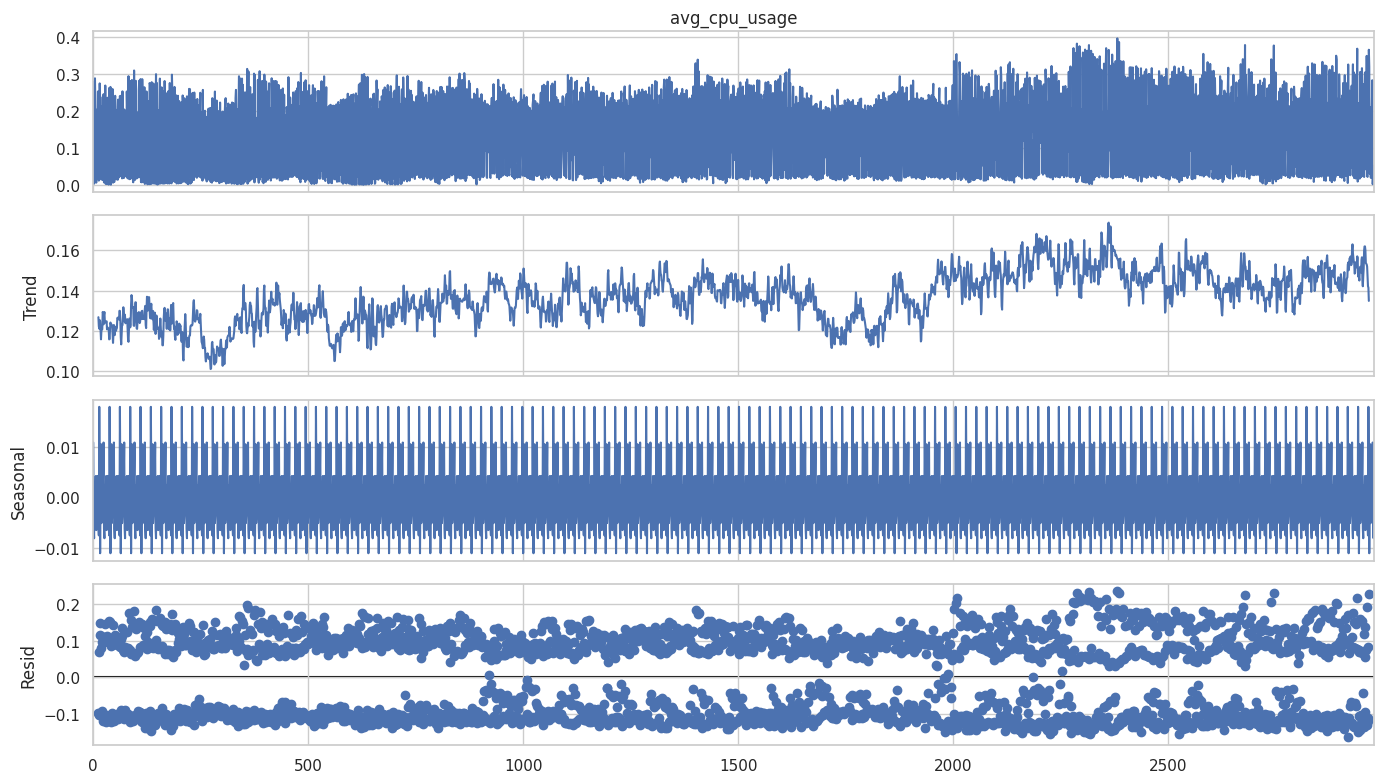

In [ ]:
# prompt: now help me to continue exploring the EDA for the itens below:
# 1. Estatísticas Descritivas
# Para começar, vamos calcular estatísticas descritivas do consumo de memória em MB, incluindo média, mediana, desvio padrão, valores mínimos e máximos. Isso ajuda a entender a distribuição geral dos dados.
# 2. Análise de Tendência e Sazonalidade
# Realizar a decomposição da série temporal em componentes de tendência, sazonalidade e resíduo. Isso permitirá identificar padrões sazonais e tendências ao longo do tempo.
# 3. Distribuição dos Valores
# Plotar histogramas e boxplots para observar a distribuição dos dados de consumo de memória. Isso é importante para detectar possíveis outliers e entender melhor a dispersão.
# 4. Análise de Correlação Temporal
# Calcular a autocorrelação para observar como os valores do consumo de memória se relacionam ao longo do tempo, ajudando a identificar periodicidades ou dependências temporais.
# 5. Análise de Ciclos de Pico e Vale
# Identificar períodos de picos e vales no consumo de memória para observar flutuações específicas e compreender os momentos de maior carga.
# Vou passar o código para cada etapa para você rodar no seu ambiente. Começaremos com as estatísticas descritivas e, conforme você for executando, me avise sobre os resultados ou qualquer dúvida!
# 6. Visualização Inicial da Série Temporal
# Primeiro, vamos analisar a série temporal para verificar padrões, sazonalidades e tendências. Isso é importante para entender a natureza dos dados antes de seguir com a modelagem.
# 7. Estatísticas Descritivas
# Calcule estatísticas como média, mediana, desvio padrão, mínimo e máximo dos valores resampleados. Isso oferece um resumo rápido da distribuição dos dados e pode ajudar a identificar outliers.
# 8. Análise de Sazonalidade e Tendência
# A decomposição da série em componentes de tendência, sazonalidade e resíduo ajudará a entender os comportamentos que podem influenciar o consumo de memória.
# 9. Visualização dos Dados de Treino e Teste
# Visualizar as divisões de t

# Existing code is already performing EDA. Enhancements and additional explorations are added below.

# --- Enhanced EDA ---

# 1. Detailed Statistics for Key Metrics (already present)

# 2. Correlation Analysis (already present)


# 3. Resource Usage Over Time by Tier (Improved Visualization) - enhanced with tooltips
print("\n--- Resource Usage Over Time by Tier (Improved Visualization) ---")

alt.data_transformers.disable_max_rows() # Allow for larger datasets in Altair


alt.Chart(hourly_usage).mark_line().encode(
    x='hour_index:N',
    y=alt.Y('avg_cpu_usage:Q', title='Average CPU Usage'),
    color='tier:N',
    tooltip=['hour_index', 'tier', 'avg_cpu_usage', 'avg_memory_usage']
).properties(
    title='CPU Usage Over Time by Tier'
).display()


alt.Chart(hourly_usage).mark_line().encode(
    x='hour_index:N',
    y=alt.Y('avg_memory_usage:Q', title='Average Memory Usage'),
    color='tier:N',
    tooltip=['hour_index', 'tier', 'avg_cpu_usage', 'avg_memory_usage']
).properties(
    title='Memory Usage Over Time by Tier'
).display()


# 4. Explore other cells (added more descriptive output)
print("\n--- Exploring other cells ---")

for c in ['a', 'b', 'c', 'e', 'f', 'g', 'h']:
  print(f"\n--- Cell {c} ---")
  try:
      hourly_usage_c = run_query_utilization_per_time_time_series(c)
      print(hourly_usage_c.describe())
      print(hourly_usage_c[['avg_cpu_usage', 'avg_memory_usage']].corr())

      alt.Chart(hourly_usage_c).mark_line().encode(
          x='hour_index:N',
          y='avg_cpu_usage:Q',
          color='tier:N'
      ).properties(
          title=f'CPU Usage in Cell {c}'
      ).display()
  except Exception as e:
      print(f"Error processing cell {c}: {e}")


# 5. Investigate Outliers (example: Identify hours with exceptionally high CPU usage) - improved clarity
print("\n--- Investigating outliers (high CPU usage) ---")

high_cpu_threshold = 0.8  # Adjustable threshold
high_cpu_hours = hourly_usage[hourly_usage['avg_cpu_usage'] > high_cpu_threshold]
if not high_cpu_hours.empty:
    print(f"Hours with CPU usage exceeding {high_cpu_threshold}:")
    print(high_cpu_hours)
else:
    print(f"No hours found with CPU usage exceeding {high_cpu_threshold}")


# 6. Boxplots to show distribution of usage per tier (added)
print("\n--- Boxplots of CPU and Memory usage ---")
alt.Chart(hourly_usage).mark_boxplot().encode(
    x='tier:N',
    y='avg_cpu_usage:Q'
).properties(title="CPU Usage Distribution per Tier").display()

alt.Chart(hourly_usage).mark_boxplot().encode(
    x='tier:N',
    y='avg_memory_usage:Q'
).properties(title="Memory Usage Distribution per Tier").display()

# 7. Time Series Decomposition (using statsmodels)
print("\n--- Time Series Decomposition ---")
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    # Example using 'avg_cpu_usage' - you can replace with other columns
    result = seasonal_decompose(hourly_usage['avg_cpu_usage'], model='additive', period=24)  # Adjust period if needed
    result.plot()
except ImportError:
    print("statsmodels not found. Please install it: !pip install statsmodels")

